In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd
import numpy as np
import re
import string
from collections import Counter
from typing import List
import multiprocessing as mp
from functools import partial
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import ast
def read_data_literals(ipath):
  outlist = []
  file = open(ipath, "r")
  for line in file:
    dictionary = ast.literal_eval(line)
    outlist.append(dictionary)
  file.close()
  return outlist

def read_data(ipath):
  outlist = []
  file = open(ipath, "r")
  for line in file:
    outlist.append(line.replace("\n", ""))
  file.close()
  return outlist

In [0]:
qasar_t_dir = "/content/drive/My Drive/quasar/quasar-t/"

In [0]:
#read the questions ans datasets
trainQ = read_data_literals(qasar_t_dir+ "questions/train_questions.json")
testQ = read_data_literals(qasar_t_dir+ "questions/test_questions.json")
devQ = read_data_literals(qasar_t_dir+ "questions/dev_questions.json")

In [6]:
np.shape(trainQ), np.shape(testQ), np.shape(devQ)

((37012,), (3000,), (3000,))

In [0]:
#read the context related dataset
trainSC = read_data_literals(qasar_t_dir+ "contexts/short/train_contexts.json")
testSC = read_data_literals(qasar_t_dir+ "contexts/short/test_contexts.json")
devSC = read_data_literals(qasar_t_dir+ "contexts/short/dev_contexts.json")

In [8]:
np.shape(trainSC), np.shape(testSC), np.shape(devSC)

((37012,), (3000,), (3000,))

In [9]:
testQ[0:2] 

[{'answer': 'queen',
  'question': 'Which is considered the most powerful piece on the chess board',
  'tags': ['1tok', 'yes-answer-long', 'yes-answer-short'],
  'uid': 's3q17641'},
 {'answer': '4',
  'question': 'If its 4:00 pm in Seattle Washington , what time is it in Portland Oregon',
  'tags': ['1tok', 'yes-answer-long', 'yes-answer-short'],
  'uid': 's3q1671'}]

In [10]:
devQ[0:2] 

[{'answer': 'tetanus',
  'question': 'Lockjaw is another name for which disease',
  'tags': ['1tok', 'yes-answer-long', 'yes-answer-short'],
  'uid': 's3q1674'},
 {'answer': 'leek',
  'question': 'Which vegetable is a Welsh emblem ?',
  'tags': ['1tok'],
  'uid': 's3q18157'}]

In [0]:
#lets find all questions with uid s3q1671 <-- just to understand the data better
uidlist_train = []
uidlist_test = []
uidlist_dev = []
for idx, Qdict in enumerate(trainQ):
  uidlist_train.append(Qdict['uid'])
for idx, Qdict in enumerate(testQ):
  uidlist_test.append(Qdict['uid'])
for idx, Qdict in enumerate(devQ):
  uidlist_dev.append(Qdict['uid'])

In [12]:
print (np.shape(uidlist_train), np.shape(list(set(uidlist_train))) )
print (np.shape(uidlist_test), np.shape(list(set(uidlist_test))) )
print (np.shape(uidlist_dev), np.shape(list(set(uidlist_dev))) )

(37012,) (37012,)
(3000,) (3000,)
(3000,) (3000,)


In [13]:
#check the common uids between train+dev and test
commonuid = list(set(uidlist_dev).intersection(set(uidlist_train)))
np.shape(commonuid)

(0,)

The UID seems unique. Every record in the train question data has a uinque UID. There are no duplicates and repeatitions. This is true for test and dev questions datasets as well as Context datasets too.
There is NO intersection between the UID of these datasets

## Lets look at the tokens (BERT like) and the length of the question and answers

In [14]:
!pip install transformers

In [0]:
import torch
from transformers import *
pretrained_weights = 'bert-base-uncased'
berttokenizer= BertTokenizer.from_pretrained(pretrained_weights)
model = BertModel.from_pretrained(pretrained_weights, 
                                  output_hidden_states=True, 
                                  output_attentions= True)

In [16]:
print(berttokenizer.tokenize("cross country riding it\u2019s a fence", add_special_tokens=False))

['cross', 'country', 'riding', 'it', '’', 's', 'a', 'fence']


In [0]:
def tokenizebertstyle(text):
  return berttokenizer.tokenize(text, add_special_tokens=False)

Text(0.5, 1.0, 'Dev dataset')

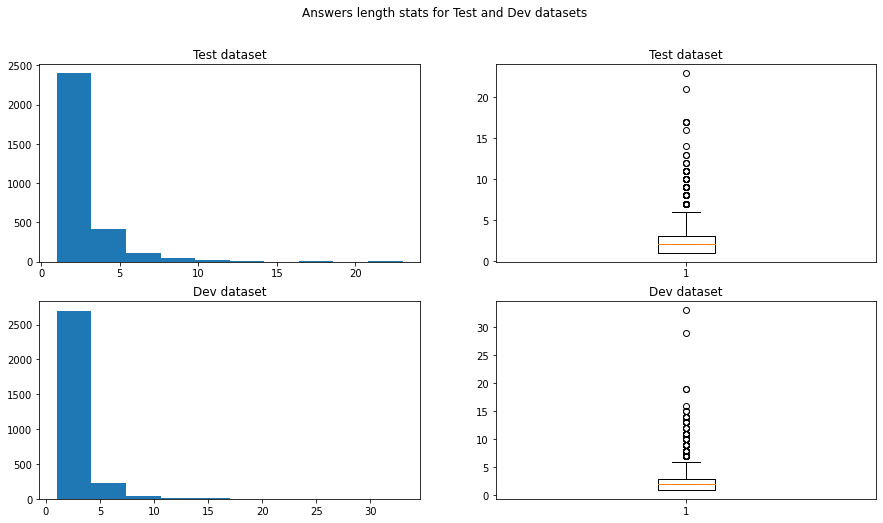

In [18]:
#lets look at length of some Answers in test and dev datasets
anslisttest = []
anslenlistdev = []
for testQdict, devQdict in zip(testQ, devQ):
  anslisttest.append(len(tokenizebertstyle(testQdict['answer'])))
  anslenlistdev.append(len(tokenizebertstyle(devQdict['answer'])))

fig, axs = plt.subplots(2, 2, figsize=(15,8))
fig.suptitle('Answers length stats for Test and Dev datasets')
axs[0, 0].hist(anslisttest)
axs[0, 0].set_title('Test dataset')
axs[0, 1].boxplot(anslisttest)
axs[0, 1].set_title('Test dataset')

axs[1, 0].hist(anslenlistdev)
axs[1, 0].set_title('Dev dataset')
axs[1, 1].boxplot(anslenlistdev)
axs[1, 1].set_title('Dev dataset')

In [19]:
pd.DataFrame(list(zip(anslisttest, anslenlistdev)), columns = ["Answer Tokens Len Test", "Answer Tokens Len Dev"]).describe()

,Answer Tokens Len Test,Answer Tokens Len Dev
count,3000.000000,3000.000000
mean,2.551333,2.557000
std,1.906981,1.987142
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,23.000000,33.000000


### Max Answer len is around 23 or33 and generally the ans are between 1-3 words

In [20]:
#it would be intresting to see the answers that have higher length
index_list_long_ans_test = [k for k, value in enumerate(anslisttest) if value > 8]
print(len(index_list_long_ans_test))
print('\n'.join([(testQ[i]["answer"]) for i in index_list_long_ans_test[:8]] )) #ony 8
print('\n')
print('\n'.join(([(testQ[i]["question"]) for i in index_list_long_ans_test[:8]]))) #ony 5

48
on a horse it\u2019s a horses leg
6 (vault, rings, floor, high bar, para bars, horse)
sighting unexplained craft sighting ufo's
it had a short head with a parrot like beak
turtle soup. calipee is found beneath the lower shell of the green turtle.
the democratic republic of congo , formally zaire
on the edge of a \u00a32 coin
a footman \u2013 walk behind master


Where would you find a gambrel
How Many Diciplines Are There In Mens Gymnastics
Close encounters of the first kind
Why Was The Psittacosaurus So Called
A green gelatinous substance known as calipee is used to make which favorite amongst gastronomes ?
In Which African Country Is The Seaport Of Banana
Where Exactly -LRB- And You Must Be Specific -RRB- Will You Find The Words `` Standing On The Shoulders Of Giants ''
In the 18th century what job did a fart-catcher do


In [21]:
#it would be intresting to see the answers that have higher length
index_list_long_ans_dev = [k for k, value in enumerate(anslenlistdev) if value > 8]
print(len(index_list_long_ans_dev))
print('\n'.join(([(devQ[i]["answer"]) for i in index_list_long_ans_dev[:8]]))) 
print('\n')
print('\n'.join(([(devQ[i]["question"]) for i in index_list_long_ans_dev[:8]]))) 

46
a giant sequoia giant sequoia
popeye - they are spinach growers
king pygmalion aphrodite life
audi \u2013 vorsprung durch technik
booze \u2013 honeymoon 30 day booze up
1 meat - 2 fresh veg \u2013 3 pet food
he tried to flee to spain instead, and was swallowed by the "whale"nineveh
hinge - it\u2019s the pin holding it


What living organism can be 30 times the size of a blue whale
Crystal City in Texas put up a statue to what cartoon character
In mythology who married the beautiful maid Galatea
What car manufacturers slogan is forward through technology
How did Attila the Hun die on honeymoon
What is the most profitable section in supermarkets
To which city did the Lord tell Jonah to go and denounce its citizens ' wickedness
Where would you find a pintle


Text(0.5, 1.0, 'Dev dataset')

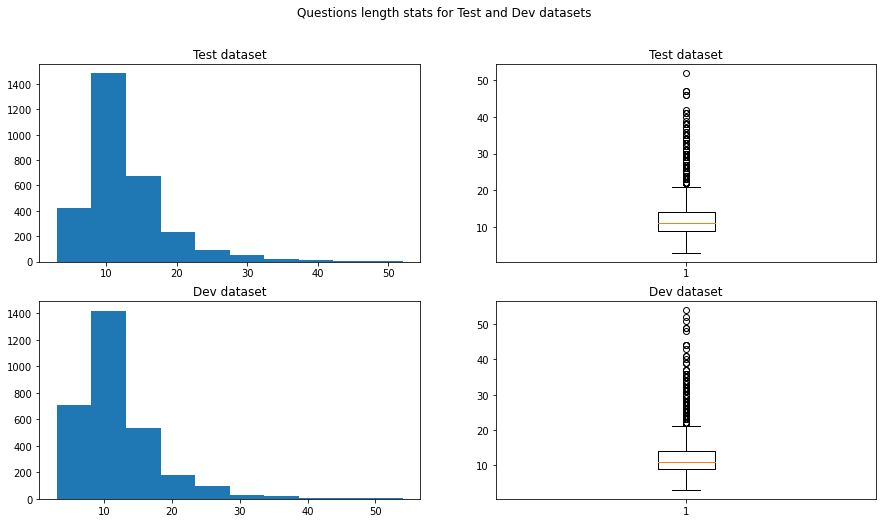

In [22]:
#lets look at length of some questions in test and dev datasets
queslenlisttest = []
queslenlistdev = []
for testQdict, devQdict in zip(testQ, devQ):
  queslenlisttest.append(len(tokenizebertstyle(testQdict['question'])))
  queslenlistdev.append(len(tokenizebertstyle(devQdict['question'])))

fig, axs = plt.subplots(2, 2, figsize=(15,8))
fig.suptitle('Questions length stats for Test and Dev datasets')
axs[0, 0].hist(queslenlisttest)
axs[0, 0].set_title('Test dataset')
axs[0, 1].boxplot(queslenlisttest)
axs[0, 1].set_title('Test dataset')

axs[1, 0].hist(queslenlistdev)
axs[1, 0].set_title('Dev dataset')
axs[1, 1].boxplot(queslenlistdev)
axs[1, 1].set_title('Dev dataset')


The distribution looks right skewed. There are questions what have as small length as 3 and as big as 41 words

In [23]:
pd.DataFrame(list(zip(queslenlisttest, queslenlistdev)), columns = ["Question Tokens Len Test", "Question Tokens Len Dev"]).describe()

,Question Tokens Len Test,Question Tokens Len Dev
count,3000.000000,3000.000000
mean,12.318000,12.312667
std,5.703951,5.784813
min,3.000000,3.000000
25%,9.000000,9.000000
50%,11.000000,11.000000
75%,14.000000,14.000000
max,52.000000,54.000000


The max length of question is 52-54 tokens and most of the questions have length between 9-14 tokens

In [24]:
index_list_long_ques_test = [k for k, value in enumerate(queslenlisttest) if value > 25]
print(len(index_list_long_ques_test))
print('\n'.join([(testQ[i]["question"]) for i in index_list_long_ques_test[:8]] )) #ony 8
print('\n')
print('\n'.join(([(testQ[i]["answer"]) for i in index_list_long_ques_test[:8]]))) #ony 8

106
A marine catfish can taste with any part of its body .The female marine catfish hatches her eggs in her __________
Where was the painting by Michaelangelo , valued at # 8 million pounds recently found , after remaining unrecognised for more than 250 years
Cocktails : Rum , lime , and cola drink make a -LRB- n -RRB- ____________ .
From the 1980 's which artists and song `` So strike a pose on a Cadillac , If you want to find all the cops , They 're hanging out in the donut shop , They sing and dance '' ?
The city of Los Angeles is more than one_third the size of the entire state of ______________
What type of food is associated with 4th July celebrations , is it a curry , a Roast Turkey , a picnic , or a BBQ ?
The four stages in the life_cycle of an insect are : egg , adult , pupa , and ________ .
On March 27 , 1964 , North America 's strongest recorded earthquake , with a moment magnitude of 9.2 , rocked central ______________


mouth
castle howard
cuba libre
the bangles / walk lik

In [25]:
index_list_long_ques_dev = [k for k, value in enumerate(queslenlistdev) if value > 25]
print(len(index_list_long_ques_dev))
print('\n'.join([(devQ[i]["question"]) for i in index_list_long_ques_dev[:8]] )) #ony 8
print('\n')
print('\n'.join(([(devQ[i]["answer"]) for i in index_list_long_ques_dev[:8]]))) #ony 8

111
______________ is the largest French_speaking city in the Western Hemisphere .
In a standard game of cricket , what is the maximum number of people that can be on the field of play at any one time during play
On the Single `` Do They Know It 's Christmas '' Only One Person Performed On Both The Original And The 20 Year Remake Band Aid 20 , Who Was It ?
In 1953 Science fiction author L.Ron Hubbard founded which cult religion , one of who 's prominent modern day followers is John Travolta
Who Had A Surprise UK Hit In The 90 's With A Cover Of The Classic Led Zeppelin Song `` Stairway To Heaven ''
In 2010 , for the first time in 27 years , the House of Reps censured one of its members , Charlie Rangel of what state ?
Most varieties of __________ can go an entire year without eating a single morsel of food .
What is the answer to a groan-inducing math riddle that asks , '' Where can you buy a ruler that is three feet long '' ?


montreal
seventeen
bono / u2
scientology
rolf harris
new 

Text(0.5, 1.0, 'Dev dataset')

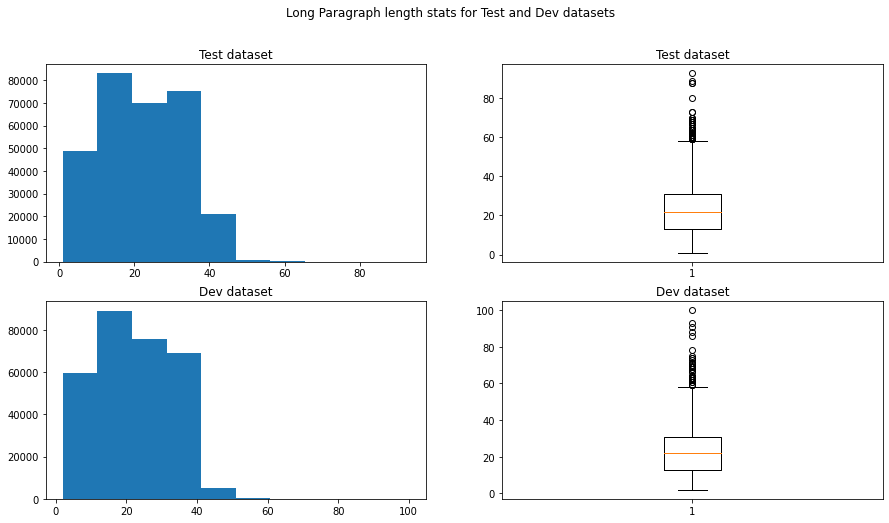

In [26]:
#lets look at length of some contexts in test and dev datasets
#since paragraphs are long and tokenization is taking longer time in evaluation hence
#using the sentence word split method to get ball park figure
Ctxlisttest = []
Ctxlistdev = []
for testSCdict, devSCdict in zip(testSC, devSC):
  sublisttestSC = testSCdict["contexts"]
  sublistdevSC = devSCdict["contexts"]
  for itemtest, itemdev in zip(sublisttestSC, sublistdevSC):
    Ctxlisttest.append(len((itemtest[1].split())))
    Ctxlistdev.append(len((itemdev[1].split())))

fig, axs = plt.subplots(2, 2, figsize=(15,8))
fig.suptitle('Long Paragraph length stats for Test and Dev datasets')
axs[0, 0].hist(Ctxlisttest)
axs[0, 0].set_title('Test dataset')
axs[0, 1].boxplot(Ctxlisttest)
axs[0, 1].set_title('Test dataset')

axs[1, 0].hist(Ctxlistdev)
axs[1, 0].set_title('Dev dataset')
axs[1, 1].boxplot(Ctxlistdev)
axs[1, 1].set_title('Dev dataset')

In [27]:
df_cxt_long = pd.DataFrame(list(zip(Ctxlisttest, Ctxlistdev)), columns = ["Paragraph Len Test", "Paragraph Len Dev"])
df_cxt_long.describe()

,Paragraph Len Test,Paragraph Len Dev
count,298355.000000,298355.000000
mean,22.175626,22.171159
std,10.537397,10.616785
min,1.000000,2.000000
25%,13.000000,13.000000
50%,22.000000,22.000000
75%,31.000000,31.000000
max,93.000000,100.000000


The word length of short paragraph vary from 10-30. Max length is 93-100. The paragraph min value is 1 or 2 words. That seems strange. It would be good to keep the min length of paragraph to 5.

In [28]:
print((df_cxt_long < 5).all(axis=1).sum()) #how many records have length less than 5

87


In [0]:
#lets try some nltk libraries to check some bert based apis
import nltk

In [0]:
from nltk.corpus import gutenberg
from nltk.tokenize.treebank import TreebankWordDetokenizer, TreebankWordTokenizer 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [0]:
#!pip uninstall tensorflow -y
#!pip install tensorflow==1.15.2

In [0]:
#!pip uninstall pandas -y
#!pip install pandas==0.25.3

In [32]:
!pip install deeppavlov

     |████████████████████████████████| 778kB 3.4MB/s 
     |████████████████████████████████| 8.0MB 11.2MB/s 
     |████████████████████████████████| 2.1MB 29.5MB/s 
     |████████████████████████████████| 6.7MB 24.7MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 7.3MB 31.9MB/s 
     |████████████████████████████████| 20.1MB 254kB/s 
     |████████████████████████████████| 61kB 8.6MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 61kB 8.5MB/s 
     |████████████████████████████████| 1.5MB 51.2MB/s 
     |████████████████████████████████| 665kB 52.7MB/s 
     |████████████████████████████████| 61kB 8.0MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |██████

In [33]:
pd.__version__

'0.25.3'

In [36]:
import tensorflow
tensorflow.__version__

'1.15.2'

In [0]:
from deeppavlov import build_model, configs
import torch

In [38]:
!python -m deeppavlov install squad_bert

2020-05-03 07:10:48.769 INFO in 'deeppavlov.core.common.file'['file'] at line 32: Interpreting 'squad_bert' as '/usr/local/lib/python3.6/dist-packages/deeppavlov/configs/squad/squad_bert.json'
  Cloning https://github.com/deepmipt/bert.git (to revision feat/multi_gpu) to /tmp/pip-req-build-2ehcjhn7
  Running command git clone -q https://github.com/deepmipt/bert.git /tmp/pip-req-build-2ehcjhn7
  Running command git checkout -b feat/multi_gpu --track origin/feat/multi_gpu
  Switched to a new branch 'feat/multi_gpu'
  Branch 'feat/multi_gpu' set up to track remote branch 'feat/multi_gpu' from 'origin'.
  Created wheel for bert-dp: filename=bert_dp-1.0-cp36-none-any.whl size=23581 sha256=ae83e20378cb186adce6f865eee9804f501058657dc9171d70f5a181aac94dc4
  Stored in directory: /tmp/pip-ephem-wheel-cache-366pi9bb/wheels/1e/41/94/886107eaf932532594886fd8bfc9cb9d4db632e94add49d326
Successfully built bert-dp


## Using pre trained Deep pavlov model trained on SQuAD

In [39]:
model = build_model(configs.squad.squad_bert, download = True)

2020-05-03 07:11:02.207 INFO in 'deeppavlov.core.data.utils'['utils'] at line 80: Downloading from http://files.deeppavlov.ai/deeppavlov_data/bert/cased_L-12_H-768_A-12.zip to /root/.deeppavlov/downloads/cased_L-12_H-768_A-12.zip
100%|██████████| 404M/404M [01:02<00:00, 6.44MB/s]
2020-05-03 07:12:04.975 INFO in 'deeppavlov.core.data.utils'['utils'] at line 242: Extracting /root/.deeppavlov/downloads/cased_L-12_H-768_A-12.zip archive into /root/.deeppavlov/downloads/bert_models
2020-05-03 07:12:09.524 INFO in 'deeppavlov.core.data.utils'['utils'] at line 80: Downloading from http://files.deeppavlov.ai/deeppavlov_data/squad_bert.tar.gz to /root/.deeppavlov/squad_bert.tar.gz
100%|██████████| 402M/402M [01:11<00:00, 5.61MB/s]
2020-05-03 07:13:21.228 INFO in 'deeppavlov.core.data.utils'['utils'] at line 242: Extracting /root/.deeppavlov/squad_bert.tar.gz archive into /root/.deeppavlov/models
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping corpora/nonbreaking_prefixes.zip.











The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.





Instructions for updating:
Use standard file APIs to check for files with this prefix.


2020-05-03 07:13:42.311 INFO in 'deeppavlov.core.models.tf_model'['tf_model'] at line 51: [loading model from /root/.deeppavlov/models/squad_bert/model]



INFO:tensorflow:Restoring parameters from /root/.deeppavlov/models/squad_bert/model


In [40]:
import tensorflow
tensorflow.__version__

'1.15.2'

In [41]:
pd.__version__

'0.25.3'

In [0]:
#!pip uninstall tensorflow -y
#!pip install tensorflow==1.15.2

## Text prerocessing Utility methods

In [0]:
def remove_articles(text):
    return re.sub(r'\b(a|an|the)\b', ' ', text)

def white_space_fix(text):
    return ' '.join(text.split())

def remove_punc(text):
    exclude = set(string.punctuation)
    return ''.join(ch for ch in text if ch not in exclude)

def lower(text):
    return text.lower()

def normalize_answer(s: str) -> str:
    return white_space_fix(remove_articles(remove_punc(lower(s))))

## F1 and Exact Match (EM) calculation methods

In [0]:
def exact_match_metric(iy_predicted_list: List[str], iground_truth: str):
  y_predicted = [normalize_answer(y_pred) for y_pred in iy_predicted_list]
  ground_truth =  normalize_answer( iground_truth )
  res = [ele for ele in y_predicted if(ele == ground_truth)]
  res = [i for i in res if i] 
  return (sum([(bool(res))]))

In [0]:
def f1_score_metric(iy_predicted_list: List[str], iground_truth: str):
  f1_total = 0.0
  precisions = []
  recalls = []
  f1s = []
  y_predicted = [normalize_answer(y_pred) for y_pred in iy_predicted_list]
  ground_truth =  normalize_answer( iground_truth )
  
  for prediction in y_predicted:
      prediction_tokens = prediction.split()
      gt_tokens = ground_truth.split()
      #print(prediction_tokens)
      #print(gt_tokens)
      if len(gt_tokens) == 0 or len(prediction_tokens) == 0:
          precisions.append(float(gt_tokens == prediction_tokens))
          recalls.append(float(gt_tokens == prediction_tokens))
          f1s.append(float(gt_tokens == prediction_tokens))
          continue
      common = Counter(prediction_tokens) & Counter(gt_tokens)
      num_same = sum(common.values())
      #print(common, num_same)
      if num_same == 0:
          precisions.append(0.0)
          recalls.append(0.0)
          f1s.append(0.0)
          continue
      precision = 1.0 * num_same / len(prediction_tokens)
      recall = 1.0 * num_same / len(gt_tokens)
      f1 = (2 * precision * recall) / (precision + recall)
      f1s.append(f1)
      precisions.append(precision)
      recalls.append(recall)

  f1_total = max(f1s)    
  return (max(precisions), max(recalls), max(f1s))

## Key function to get the predicted Answer from the Model

In [0]:
def get_predicted_answer(iQues, iContext, imodel, 
                         itopN_pred_ans, iRemove_word_list, id):
  
  """
  Tokenize the context containing multiple paragraphs
  Each para  - broken to sentence
  """
  paras = []
  words = []
  predicted_ans = ""
  y_predicted_lst = []
  
  count_sent= 0
  for ConextDict in iContext[id:id+1]:
    sublist = ConextDict["contexts"]
    for i, item in enumerate(sublist):
      sent = (item[1]) #TreebankWordDetokenizer().detokenize(item[1])
      if((len(sent.split()) >= 5) & (count_sent <= itopN_pred_ans) ):
        #print(id, sent)
        paras.append(sent)
        count_sent = count_sent + 1
      
      
  ##lets do the same for the question
  ques_dict = iQues[id:id+1][0]
  ques = (ques_dict['question'])

  #get model prediction
  predicted_ans_list = []
  for para in paras:
    predicted_ans = imodel([para], [ques])
    predicted_ans_list.append(sum(predicted_ans, []))
    #print(predicted_ans)  
  
  predicted_ans_list = sorted(predicted_ans_list, key = lambda x: x[2], 
                                reverse=True)
  for i in range(count_sent-1):
    word_list = lower(predicted_ans_list[i][0]).split()
    predicted_ans_list[i][0] = (' '.join(
        [i for i in word_list if i not in iRemove_word_list]))
    y_predicted_lst.append(predicted_ans_list[i][0])
  
  
  actual_ans = ques_dict['answer']
  print (id, len(y_predicted_lst), y_predicted_lst, ',' ,normalize_answer( actual_ans ))

  EM = exact_match_metric(y_predicted_lst, actual_ans)
  precision, recall, f1 = f1_score_metric(y_predicted_lst, actual_ans)

  return  y_predicted_lst, [normalize_answer(actual_ans), normalize_answer(ques), EM, precision, recall, f1]


# Run the model on Dev Data - only first 200 records due to RAM size and time limitation

In [0]:
deemed_outlier_index_dev = index_list_long_ques_dev +  index_list_long_ans_dev
deemed_outlier_index_dev = list(set(deemed_outlier_index_dev)) #remove duplicates
print(len(deemed_outlier_index_dev))
print((deemed_outlier_index_dev))

157
[1540, 2053, 519, 2569, 1548, 1549, 16, 528, 22, 2070, 1055, 2080, 33, 543, 556, 47, 2608, 563, 2611, 2101, 1589, 2618, 2107, 2619, 2113, 1090, 1091, 73, 2638, 80, 1622, 2139, 2146, 614, 1639, 618, 619, 1137, 1650, 1140, 1652, 2164, 1655, 120, 1662, 639, 643, 135, 652, 1677, 1678, 655, 1680, 1681, 663, 1687, 1690, 155, 1179, 1182, 1697, 2721, 2729, 1199, 1201, 2227, 2231, 1210, 1731, 1222, 198, 724, 725, 1237, 2264, 2776, 219, 220, 1755, 234, 2287, 2299, 1788, 1279, 1792, 257, 1798, 2311, 2825, 1294, 784, 2322, 2838, 1816, 2842, 797, 798, 1310, 1823, 2848, 800, 2342, 2344, 299, 1839, 1840, 2352, 821, 1341, 1343, 2375, 2887, 845, 343, 1368, 2903, 347, 1886, 1893, 2920, 360, 1390, 1904, 374, 1912, 1402, 890, 381, 897, 1936, 913, 1426, 2967, 2971, 1950, 930, 2988, 2477, 2989, 945, 1460, 2485, 2491, 967, 1484, 1485, 2001, 2523, 478, 2014, 2527, 995, 486, 1517, 1532, 1021, 1022]


In [0]:
# ignore outliers
devQtmp = [i for j, i in enumerate(devQ) if j not in deemed_outlier_index_dev]
devSCtmp = [i for j, i in enumerate(devSC) if j not in deemed_outlier_index_dev]
print (len(devQtmp), len (devSCtmp))

2843 2843


In [0]:
devQtmp[:2]

[{'answer': 'tetanus',
  'question': 'Lockjaw is another name for which disease',
  'tags': ['1tok', 'yes-answer-long', 'yes-answer-short'],
  'uid': 's3q1674'},
 {'answer': 'leek',
  'question': 'Which vegetable is a Welsh emblem ?',
  'tags': ['1tok'],
  'uid': 's3q18157'}]

In [0]:
import time

#using top 5 scored passages as per QUASAR dataset  
itopN_pred_ans = 50
#using only first 200 records due to RAM and runtime limitation
n_records = 200

#some special chars related to brackets are removed
Remove_word_list = ['lrb-' , '-rrb', '-lrb-', '-lsb-', '-rrb-', '-rsb-']

pred_ans_list_col_names = {}

"""
  build the dataframe to store the results
  df_pred - storing predicted ans based on the itopN_pred_ans passages count
  df_metrics - storing prediction metrics
"""
#initializing the dataframes
for i in range(itopN_pred_ans):
  pred_ans_list_col_names[('pred_ans_' + str(i))] = []

df_pred= pd.DataFrame(pred_ans_list_col_names)
df_metrics = pd.DataFrame({'actual_ans': [], 'actual_ques': [], 'EM': [], 'precision': [], 'recall': [], 'f1': []})

"""
 Running prediction loop
"""
t1 = time.time() #time it

count = 0
for id in range(len(devQtmp)):
  pred, metrics = get_predicted_answer(devQtmp, devSCtmp, model, itopN_pred_ans, Remove_word_list, id)
  count = count + 1
  if (count >= n_records):
    break
  
  for i in  range(len(pred)):
    pred_ans_list_col_names[('pred_ans_' + str(i))] = pred[i]

  df_pred = df_pred.append(pred_ans_list_col_names, ignore_index=True)

  df_metrics = df_metrics.append({'actual_ans': metrics[0], 'actual_ques': metrics[1], 'EM': metrics[2], 
                              'precision': metrics[3], 'recall': metrics[4], 'f1': metrics[5]}, ignore_index=True)

t2 = time.time()
print('Time for whole code to run: ', (t2-t1))

0 50 ['tetanus', 'tetanus', 'tetanus', 'tetanus', 'clostridium tetani', 'tetanus tetanus', 'masseter muscle spasm', 'liver cancer', 'tetanus -lrb', 'tetanus tetanus', 'tetanus', 'tetanus', 'tetanus lockjaw tetanus', 'pertussis', 'tetanus -lrb', 'tetanus', 'tetanus', 'tuberculosis', 'tetanus', 'cephalic tetanus', 'tetanus', 'influenza', 'papillomas', 'tetanus', 'pharyngeal diphtheria', 'tetanus', 'tetanus', 'fact tetanus', 'tetanus -lrb', 'muscle spasms', 'seizures', 'brain or nervous system disease', 'lrb', 'tetanus', 'infectious disease', 'vaccine', 'vaccine', 'clostridium tetani', 'jaw muscles', 'type of vaccine', 'the disease is sometimes called lockjaw', 'tetanus', "legionnaires ' disease", 'lockjaw', 'respiratory obstruction', 'stiff jaw', 'lockjaw', 'vaccine', 'infections', 'the disease gets its common name from .'] , tetanus
1 50 ['daffodil', 'leek', 'leek', 'leek', 'leek', 'leek', 'leek', 'daffodil', 'leek', 'daffodils', 'leek -lrb', 'leek', 'leek', 'leek', 'triban', 'red drago

In [0]:
df_pred.head()

,pred_ans_0,pred_ans_1,pred_ans_2,pred_ans_3,pred_ans_4,pred_ans_5,pred_ans_6,pred_ans_7,pred_ans_8,pred_ans_9,pred_ans_10,pred_ans_11,pred_ans_12,pred_ans_13,pred_ans_14,pred_ans_15,pred_ans_16,pred_ans_17,pred_ans_18,pred_ans_19,pred_ans_20,pred_ans_21,pred_ans_22,pred_ans_23,pred_ans_24,pred_ans_25,pred_ans_26,pred_ans_27,pred_ans_28,pred_ans_29,pred_ans_30,pred_ans_31,pred_ans_32,pred_ans_33,pred_ans_34,pred_ans_35,pred_ans_36,pred_ans_37,pred_ans_38,pred_ans_39,pred_ans_40,pred_ans_41,pred_ans_42,pred_ans_43,pred_ans_44,pred_ans_45,pred_ans_46,pred_ans_47,pred_ans_48,pred_ans_49
0,tetanus,tetanus,tetanus,tetanus,clostridium tetani,tetanus tetanus,masseter muscle spasm,liver cancer,tetanus -lrb,tetanus tetanus,tetanus,tetanus,tetanus lockjaw tetanus,pertussis,tetanus -lrb,tetanus,tetanus,tuberculosis,tetanus,cephalic tetanus,tetanus,influenza,papillomas,tetanus,pharyngeal diphtheria,tetanus,tetanus,fact tetanus,tetanus -lrb,muscle spasms,seizures,brain or nervous system disease,lrb,tetanus,infectious disease,vaccine,vaccine,clostridium tetani,jaw muscles,type of vaccine,the disease is sometimes called lockjaw,tetanus,legionnaires ' disease,lockjaw,respiratory obstruction,stiff jaw,lockjaw,vaccine,infections,the disease gets its common name from .
1,daffodil,leek,leek,leek,leek,leek,leek,daffodil,leek,daffodils,leek -lrb,leek,leek,leek,triban,red dragon,thyroid gland,leek,porrum,beans,pungent vegetable,cadillac,red rose,pewter,dragon,boiled,lunch,seedlings,triskelion,myddfai,dragon,cymru,roman,rabbit,cymru,legs,green,flower,brew,winter vegetable,the vegetable,leeks,rabbit,brew,brew,"it is the accepted emblem of king arthur , the...",vegetable,concoction,the emblem as used by the obod is surrounded b...,
2,west side story,2001 : a space odyssey,tender mercies,gate o,jan sv r k 's kolya,"crouching tiger , hidden dragon",american beauty,1967,the rains came,the invisible man,revanche,the godfather,west side story,wyler 's 1959 ben-hur,the virgin spring,life is beautiful,jim rygiel joe letteri ra,"the assault in 1987 , antonia 's line",the hustler -lrb,sayonara,the godfather,casanova di federico fellini,anatomy of a murder,it won the academy award for best animated sho...,1953,lead,lsb- 1 -rsb,special rules for the best foreign language fi...,the `` greatest,frank sinatra,berlin international film festival,special rules for the best foreign language fi...,it was nominated for best actor in a leading role,special rules for the best foreign language fi...,best actress oscar winners appeared in a best ...,jackson and weta,20th century 's best picture,best actor,special rules for the best foreign language fi...,1972,the category was called best special effects w...,jackson,1963,,,best picture,the film they won the oscar for and the year a...,best actor,,"dancing clothes , a bicycle without a rider , ..."
3,sittin on the dock,`` my girl,the dock of the bay,`` tramp,respect the original,paying tribute to otis redding after 40 years,lovey dovey,sittin ' on the dock of the bay,` sittin ' on the dock of the bay,` sweet soul music,plane,dock of the bay,i 've been loving you too long,otis blue,plane crash into lake,1 otis redding featu,his posthumous number one single '' s,released posthumously,i 'm coming home 15 .,,the dock of the bay,it was redding 's first live album,,the dock of the bay,otis blue deluxe set coming april 22 rhino ent...,what does o,his tour airplane crashed into lake monon near...,release of his first single,monterey monterey 1967,what if,family coming to stax museum for public events,johnny jenkins who had a regional hit,otis reding arnold says : 2008 jul 07 13:57 ot...,,,,,1967,hendrix,,he became the saint of soul,song,his untimely death in a plane crash in decembe...,hip-hop,1967,the album featured music recorded but not rele...,1967,"december 7 , 1967",` upbeat,otis redding has left behind music that is imm...
4,herod antipas,herod antipas,flavius josephus,herod antipas,herod,the forerunner,the king of the jews,her

In [0]:
df_metrics.head()

,actual_ans,actual_ques,EM,precision,recall,f1
0,tetanus,lockjaw is another name for which disease,1.0,1.000000,1.000000,1.000000
1,leek,which vegetable is welsh emblem,1.0,1.000000,1.000000,1.000000
2,guns of naverone,which film won best special effects oscar in 1961,0.0,0.333333,0.333333,0.333333
3,sitting on dock of bay,what was otis redding s biggest hit coming aft...,0.0,1.000000,0.800000,0.800000
4,king herod,who ordered john baptists execution,1.0,1.000000,1.000000,1.000000


In [0]:
df_metrics['f1'].mean(), df_metrics['EM'].mean(), df_metrics['precision'].mean() , df_metrics['recall'].mean() 

(0.7854989231873657,
 0.6633165829145728,
 0.8052524527398899,
 0.8164273749700887)

In [0]:
df_merge = pd.concat([df_pred, df_metrics], axis=1)
df_merge['dataset'] = "quasar_t_short_dev"
df_merge.columns

Index(['pred_ans_0', 'pred_ans_1', 'pred_ans_2', 'pred_ans_3', 'pred_ans_4',
       'pred_ans_5', 'pred_ans_6', 'pred_ans_7', 'pred_ans_8', 'pred_ans_9',
       'pred_ans_10', 'pred_ans_11', 'pred_ans_12', 'pred_ans_13',
       'pred_ans_14', 'pred_ans_15', 'pred_ans_16', 'pred_ans_17',
       'pred_ans_18', 'pred_ans_19', 'pred_ans_20', 'pred_ans_21',
       'pred_ans_22', 'pred_ans_23', 'pred_ans_24', 'pred_ans_25',
       'pred_ans_26', 'pred_ans_27', 'pred_ans_28', 'pred_ans_29',
       'pred_ans_30', 'pred_ans_31', 'pred_ans_32', 'pred_ans_33',
       'pred_ans_34', 'pred_ans_35', 'pred_ans_36', 'pred_ans_37',
       'pred_ans_38', 'pred_ans_39', 'pred_ans_40', 'pred_ans_41',
       'pred_ans_42', 'pred_ans_43', 'pred_ans_44', 'pred_ans_45',
       'pred_ans_46', 'pred_ans_47', 'pred_ans_48', 'pred_ans_49',
       'actual_ans', 'actual_ques', 'EM', 'precision', 'recall', 'f1',
       'dataset'],
      dtype='object')

In [0]:
writePath = qasar_t_dir + "questions/short_metric_dev.csv"
df_merge.to_csv(writePath)

In [0]:
"""
*** UNUSED
writePath = qasar_t_dir + "questions/long_metric_test.txt"
df_.to_csv(writePath)
with open(writePath, 'a') as f:
    f.write(df_metrics.to_string(header = False, index = False))
f.close()
"""

'\n*** UNUSED\nwritePath = qasar_t_dir + "questions/long_metric_test.txt"\ndf_.to_csv(writePath)\nwith open(writePath, \'a\') as f:\n    f.write(df_metrics.to_string(header = False, index = False))\nf.close()\n'

# Now Running the Test dataset
#### The code code be optimized by defining a common function - TBD

In [46]:
deemed_outlier_index_test = index_list_long_ques_test +  index_list_long_ans_test
deemed_outlier_index_test = list(set(deemed_outlier_index_test)) #remove duplicates
print(len(deemed_outlier_index_test))
print((deemed_outlier_index_test))

151
[1024, 1034, 2059, 2058, 2574, 2066, 1558, 537, 2075, 2593, 34, 1059, 45, 562, 1081, 1086, 2622, 577, 66, 580, 2630, 2636, 2637, 78, 1612, 80, 2129, 595, 2131, 1108, 2137, 1114, 603, 2650, 607, 98, 2155, 1142, 1663, 2176, 642, 1667, 644, 2181, 2694, 1162, 1165, 142, 143, 2706, 1684, 2708, 2712, 1178, 2715, 1182, 2210, 166, 1705, 1707, 1709, 2235, 701, 2241, 2753, 2244, 2758, 1742, 2255, 2768, 1233, 724, 1756, 2780, 1758, 2783, 1760, 2270, 2275, 2277, 2279, 2285, 754, 2291, 2302, 1791, 771, 267, 1291, 2319, 788, 1820, 2339, 1832, 298, 811, 1836, 303, 2353, 2871, 1339, 2877, 2884, 1867, 844, 1358, 2895, 1367, 346, 348, 2909, 353, 354, 355, 2913, 2916, 2416, 2929, 1398, 1913, 892, 895, 384, 2943, 2434, 2436, 1413, 2949, 1927, 2957, 912, 403, 925, 1953, 1450, 2991, 944, 432, 1458, 2999, 957, 452, 2509, 466, 979, 2520, 2022, 2552, 1530, 2043, 1535]


In [47]:
# ignore outliers
testQtmp = [i for j, i in enumerate(testQ) if j not in deemed_outlier_index_test]
testSCtmp = [i for j, i in enumerate(testSC) if j not in deemed_outlier_index_test]
print (len(testQtmp), len (testSCtmp))

2849 2849


In [48]:
testQtmp[:2]

[{'answer': 'queen',
  'question': 'Which is considered the most powerful piece on the chess board',
  'tags': ['1tok', 'yes-answer-long', 'yes-answer-short'],
  'uid': 's3q17641'},
 {'answer': '4',
  'question': 'If its 4:00 pm in Seattle Washington , what time is it in Portland Oregon',
  'tags': ['1tok', 'yes-answer-long', 'yes-answer-short'],
  'uid': 's3q1671'}]

In [49]:
import time

#using top 5 scored passages as per QUASAR dataset  
itopN_pred_ans = 40
#using only first 200 records due to RAM and runtime limitation
n_records = 200

#some special chars related to brackets are removed
Remove_word_list = ['lrb-' , '-rrb', '-lrb-', '-lsb-', '-rrb-', '-rsb-']

pred_ans_list_col_names = {}

"""
  build the dataframe to store the results
  df_pred - storing predicted ans based on the itopN_pred_ans passages count
  df_metrics - storing prediction metrics
"""
#re init the dataframes
for i in range(itopN_pred_ans):
  pred_ans_list_col_names[('pred_ans_' + str(i))] = []
df_pred= pd.DataFrame(pred_ans_list_col_names)
df_metrics = pd.DataFrame({'actual_ans': [], 'actual_ques': [], 'EM': [], 'precision': [], 'recall': [], 'f1': []})

"""
 Running prediction loop
"""
t1 = time.time() #time it

count = 0
for id in range(len(testQtmp)):
  pred, metrics = get_predicted_answer(testQtmp, testSCtmp, model, itopN_pred_ans, Remove_word_list, id)
  count = count + 1
  if (count >= n_records):
    break
  
  for i in  range(len(pred)):
    pred_ans_list_col_names[('pred_ans_' + str(i))] = pred[i]

  df_pred = df_pred.append(pred_ans_list_col_names, ignore_index=True)

  df_metrics = df_metrics.append({'actual_ans': metrics[0], 'actual_ques': metrics[1], 'EM': metrics[2], 
                              'precision': metrics[3], 'recall': metrics[4], 'f1': metrics[5]}, ignore_index=True)

t2 = time.time()
print('Time for whole code to run: ', (t2-t1))

0 40 ['queen', 'the queen the queen', 'queen', 'queen', 'the queen', "rook 's movement queen", 'the queen', 'the queen', 'the queen', 'queen', 'the king', 'queen', 'the king', 'the queen', 'the king', 'the queen', 'rook', 'the king', 'the queen', 'the queen', 'the queen', 'queen', 'the pawn', "queen 's movement king", 'kings', 'queen', 'the king', 'queen', 'the queen', 'queen', 'the queen', 'chess', 'they', 'it , too , is considered a minor piece', 'it is not considered a sound move', 'she', 'they are the least powerful piece', "it 's the most important piece", 'what might otherwise be considered a more powerful piece for her', 'it is the most powerful piece'] , queen
1 40 ['what to do in portland if/when it rains', '10:40', 'overnight', '1pm', 'real speed date', '10:00 a.m', '4 www', '07:12 pm', 'today', '4', 'what to do with 5yo & 2yo', '4', '4:43 pm', 'seattle freeze', '6:00 pm pst saturday : 9:00 am - 3:00 pm', 'cost', 'washington', '4', 'lrb', 'oregon', 'harney', '4', '20', 'portl

In [50]:
df_pred.head()

,pred_ans_0,pred_ans_1,pred_ans_2,pred_ans_3,pred_ans_4,pred_ans_5,pred_ans_6,pred_ans_7,pred_ans_8,pred_ans_9,pred_ans_10,pred_ans_11,pred_ans_12,pred_ans_13,pred_ans_14,pred_ans_15,pred_ans_16,pred_ans_17,pred_ans_18,pred_ans_19,pred_ans_20,pred_ans_21,pred_ans_22,pred_ans_23,pred_ans_24,pred_ans_25,pred_ans_26,pred_ans_27,pred_ans_28,pred_ans_29,pred_ans_30,pred_ans_31,pred_ans_32,pred_ans_33,pred_ans_34,pred_ans_35,pred_ans_36,pred_ans_37,pred_ans_38,pred_ans_39
0,queen,the queen the queen,queen,queen,the queen,rook 's movement queen,the queen,the queen,the queen,queen,the king,queen,the king,the queen,the king,the queen,rook,the king,the queen,the queen,the queen,queen,the pawn,queen 's movement king,kings,queen,the king,queen,the queen,queen,the queen,chess,they,"it , too , is considered a minor piece",it is not considered a sound move,she,they are the least powerful piece,it 's the most important piece,what might otherwise be considered a more powe...,it is the most powerful piece
1,what to do in portland if/when it rains,10:40,overnight,1pm,real speed date,10:00 a.m,4 www,07:12 pm,today,4,what to do with 5yo & 2yo,4,4:43 pm,seattle freeze,6:00 pm pst saturday : 9:00 am - 3:00 pm,cost,washington,4,lrb,oregon,harney,4,20,portland oregon its not ok,portland vs. boulder vs. seattle its a battle,any native new yorkers,or,,canteen,,home our practice,portland,disc jockey service,portland,vend northwest,,"vancouver , b.c.",,,home our practice
2,john bailey,george roy hill,robert redford,robert redford,robert redford,robert redford,robert redford,redford,donald sutherland,redford,robert redford,robert redford,redford,robert redford,donald sutherland,jarrett,colin jacobson,guest,judith guest,guest,,,direc,the deer hunter,,,,that was ordinary people !,,,it lost the best picture academy award to ordi...,ordinary people -lrb,,,,,ordinary people,an extraordinary motion picture,`` ordinary people,ordinary people
3,hobgoblins 2,lsb- it -rsb,spares,wikipedia,the 25 worst sequels,wikipedia,wikipedia,wikipedia,wikipedia,wikipedia,wikipedia,wikipedia,wikipedia,wikipedia,wikipedia,it was rated by entertainment weekly as one of...,george clooney,lsb- 2 -rsb,lsb- 14 -rsb,lsb- 66 -rsb,the film was criticized amongst fans and consi...,the film,the 50 worst movies ever made,the 50 worst movies ever made,the film,the film,lsb- 18 -rsb,superhero film,movie,the 50 worst movies ever made,huyck and katz,the 50 worst movies ever made,this version is generally considered a major i...,superhero film,superhero film,superhero film,it,superhero film,superhero film,it is often considered one of the worst movies
4,parrot,lories,neotropical parrots,parrots,parrots,new world parrots,birds of the parrot fami,it is the largest living species of bird,birds of the parrot family,parrot type,bird,parrot family,mini macaws,the greenwing,parrots in the world,hyacinth macaw,harlequin macaw - one of the more colorful of ...,the larger macaws are definitely for the most ...,birds,those on st. lucia and st. vincent,the most familiar and `` classic,military,scarlets,shamrock macaws are a very colorful hybrid macaw,scarlet macaws are said to be found in nicaragua,these are the most commonly available,tanagers,the yellow collar is the second largest of the...,most macaws love to splash around in a lukewar...,this makes them one of the largest macaws .,shamrock macaw - shamrock macaws are a very co...,red,colorful plumages,one of the most recognizable bird groups in th...,all,this genus contains 11 of the 17 species,these macaws are a bit more colorful than most...,macaws,macaws are known for their often colorful plumage,clay lick


In [51]:
df_metrics.head()

,actual_ans,actual_ques,EM,precision,recall,f1
0,queen,which is considered most powerful piece on che...,1.0,1.000,1.00,1.000000
1,4,if its 400 pm in seattle washington what time ...,1.0,1.000,1.00,1.000000
2,robert redford,who directed film ordinary people,1.0,1.000,1.00,1.000000
3,attack of killer tomatoes,what film is generally considered worst film e...,0.0,0.125,0.25,0.166667
4,parrot family,macaws are largest and most colorful species of,1.0,1.000,1.00,1.000000


In [52]:
df_metrics['f1'].mean(), df_metrics['EM'].mean(), df_metrics['precision'].mean() , df_metrics['recall'].mean() 

(0.7527812221279563,
 0.6231155778894473,
 0.7835523772709703,
 0.7770519262981574)

In [53]:
df_merge = pd.concat([df_pred, df_metrics], axis=1)
df_merge['dataset'] = "quasar_t_short_test"
df_merge.columns

Index(['pred_ans_0', 'pred_ans_1', 'pred_ans_2', 'pred_ans_3', 'pred_ans_4',
       'pred_ans_5', 'pred_ans_6', 'pred_ans_7', 'pred_ans_8', 'pred_ans_9',
       'pred_ans_10', 'pred_ans_11', 'pred_ans_12', 'pred_ans_13',
       'pred_ans_14', 'pred_ans_15', 'pred_ans_16', 'pred_ans_17',
       'pred_ans_18', 'pred_ans_19', 'pred_ans_20', 'pred_ans_21',
       'pred_ans_22', 'pred_ans_23', 'pred_ans_24', 'pred_ans_25',
       'pred_ans_26', 'pred_ans_27', 'pred_ans_28', 'pred_ans_29',
       'pred_ans_30', 'pred_ans_31', 'pred_ans_32', 'pred_ans_33',
       'pred_ans_34', 'pred_ans_35', 'pred_ans_36', 'pred_ans_37',
       'pred_ans_38', 'pred_ans_39', 'actual_ans', 'actual_ques', 'EM',
       'precision', 'recall', 'f1', 'dataset'],
      dtype='object')

In [0]:
writePath = qasar_t_dir + "questions/short_metric_test.csv"
df_merge.to_csv(writePath)

In [0]:
"""
writePath = qasar_t_dir + "questions/long_metric_dev.txt"
with open(writePath, 'a') as f:
    f.write(df_metrics.to_string(header = False, index = False))
f.close()
"""